In [1]:
import sys
# sys.path.append("/ibkr")

import os
import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pytz


import passwords
from databaseClass import DB
from utilsl2 import generate_df_from_sql_file, generate_list_from_sql_file
from utilsl2 import DataProcessor
from utilsl2 import ModelBuilder
from utilsl2 import Predictor
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sql_files import queries

2023-07-21 17:27:28.497782: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-21 17:27:28.602251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Restrict TensorFlow to only use the first GPU
    tf.config.set_visible_devices(gpus[0], 'GPU')

    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2023-07-21 17:27:29.780788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-21 17:27:29.789933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-21 17:27:29.790015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Fri Jul 21 17:27:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   53C    P2    60W / 350W |   2581MiB / 12288MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
userName = passwords.userName
userPass = passwords.userPass
dataBaseName = passwords.dataBaseName
host = passwords.host

In [7]:
db = DB(userName=userName, userPass=userPass, dataBaseName=dataBaseName, host='ibkr_db', docker=True)

In [8]:
df = db.DBtoDF(queries.sql_l2)

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


In [9]:
df.head()

,position,operation,side,price,size,timestamp
0,0,0,1,4579.00,68,2023-07-21 15:35:30.542088
1,1,0,1,4578.75,95,2023-07-21 15:35:30.569578
2,2,0,1,4578.50,109,2023-07-21 15:35:30.576519
3,3,0,1,4578.25,124,2023-07-21 15:35:30.587448
4,4,0,1,4578.00,121,2023-07-21 15:35:30.594338


In [10]:
def main_build_model(df, look_ahead=5, TIME_STEPS=60, epochs=50):
    
    # Create a DataProcessor instance
    processor = DataProcessor(df) 
    # Process the df
    processor.process_df()
    print(processor.processed_df.head(10))
    
    # Scale and shift the data
    scaler, close_scaler = processor.scale_shift_data(look_ahead)
    # Create the X and y datasets
    X, y = processor.scaled_df, processor.shifted_df['price_0_0']
    # Create train test split
    X_train, X_test, y_train, y_test = processor.create_train_test_split(X, y)   
    # Create final train and test datasets

    X_train, y_train = processor.create_dataset(X_train, y=y_train, time_steps=TIME_STEPS, for_training=True, look_ahead=look_ahead)
    X_test, y_test = processor.create_dataset(X_test, y=y_test, time_steps=TIME_STEPS, for_training=True, look_ahead=look_ahead)

    # Number of features in the data
    n_features = X_train.shape[2]
    
    # Create a ModelBuilder instance and build the model
    builder = ModelBuilder(n_features, TIME_STEPS)
    # Train the model
    model, history = builder.train_model(X_train, y_train, X_test, y_test, epochs=epochs, batch_size=64)
    # Save the model
    model_path = 'models/model.h5'
    builder.save_model(model_path)
    # Plot loss
    builder.plot_loss(history)

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


                             price_0_0    price_0_1    price_1_0    price_1_1  \
timestamp                                                                       
2023-07-21 15:35:30+00:00  4579.250000  4579.000000  4579.500000  4578.750000   
2023-07-21 15:35:31+00:00  4579.312500  4579.062500  4579.562500  4578.833333   
2023-07-21 15:35:32+00:00  4579.125000  4578.875000  4579.333333  4578.583333   
2023-07-21 15:35:33+00:00  4579.115385  4578.854167  4579.406250  4578.613636   
2023-07-21 15:35:34+00:00  4579.113636  4578.861111  4579.375000  4578.625000   
2023-07-21 15:35:35+00:00  4578.958333  4578.708333  4579.208333  4578.375000   
2023-07-21 15:35:36+00:00  4579.125000  4578.875000  4579.375000  4578.625000   
2023-07-21 15:35:37+00:00  4579.000000  4578.750000  4579.250000  4578.500000   
2023-07-21 15:35:38+00:00  4579.000000  4578.750000  4579.250000  4578.500000   
2023-07-21 15:35:39+00:00  4579.000000  4578.750000  4579.250000  4578.500000   

                           

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


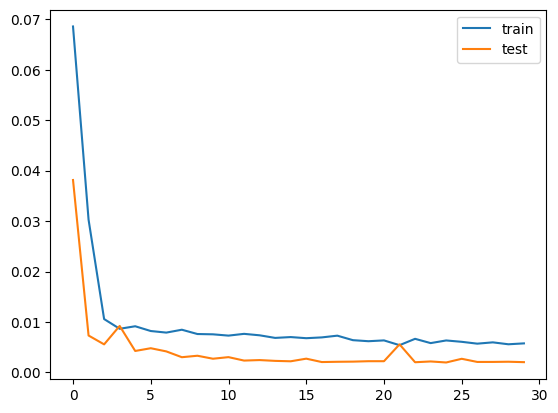

In [11]:
df = db.DBtoDF(queries.sql_l2)
main_build_model(df, look_ahead=5, TIME_STEPS=60, epochs=30)

http://localhost:6006/#timeseries